# Single Digit Memorization Visualizations

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os

In [4]:
import torch
import pickle
import networkx as nx
import seaborn as sns

import circuit_visual as cv

In [27]:
# get all of the tasks that have been patched
tasks = os.listdir("../data/patching_circuit")
tasks = set(map(lambda x: x[0:3], tasks))

In [11]:
for task in tasks:
    attn_patching = pickle.load(open(f"../data/patching_circuit/{task}-all_blocks.pkl", "rb"))
    # sns.heatmap(attn_patching, cmap="viridis", vmin=0)
    heads = cv.get_top_attn_heads(attn_patching, 0.1)
    nodes, edges, vals = cv.attn_heads_multipartite(heads)
    G, pos, cvals = cv.make_circuit_graph(nodes, edges, vals, color="viridis", scale=2)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    nx.draw_networkx_edges(G, pos, arrows=True, width=1, arrowsize=10)
    
    for node, in zip(G.nodes()):
        color = "white" if "MLP" in node else cvals[node]
        cv.draw_rounded_node(ax, pos, node, color, width=0.2, height=0.05)
    
    # plt.autoscale()
    ax.axis('off')
    plt.axis("scaled")
    
    plt.savefig(f"{task}-circuit.pdf")
    plt.close()

<Axes: >

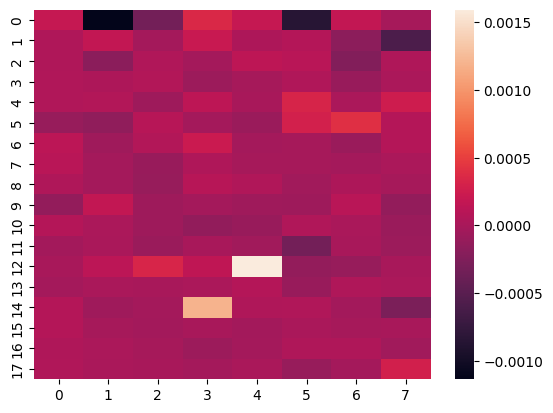

In [13]:
sns.heatmap(attn_patching)

In [28]:
# plot the covariance
attn_scores = {}
for task in tasks:
    attn_patching = pickle.load(open(f"../data/patching_circuit/{task}-all_blocks.pkl", "rb"))
    attn_scores[task] = attn_patching

In [8]:
import numpy as np

In [9]:
hm = np.zeros((len(attn_scores), len(attn_scores)))

keys = list(attn_scores.keys())

keys.sort(key=lambda x : (int(x[0]), int(x[2])))

for i, k1 in enumerate(keys):
    for j, k2 in enumerate(keys):
        v1 = attn_scores[k1].flatten()
        v2 = attn_scores[k2].flatten()
        pc = np.corrcoef(v1, v2)[0,1] ** 2
        hm[i,j] = pc

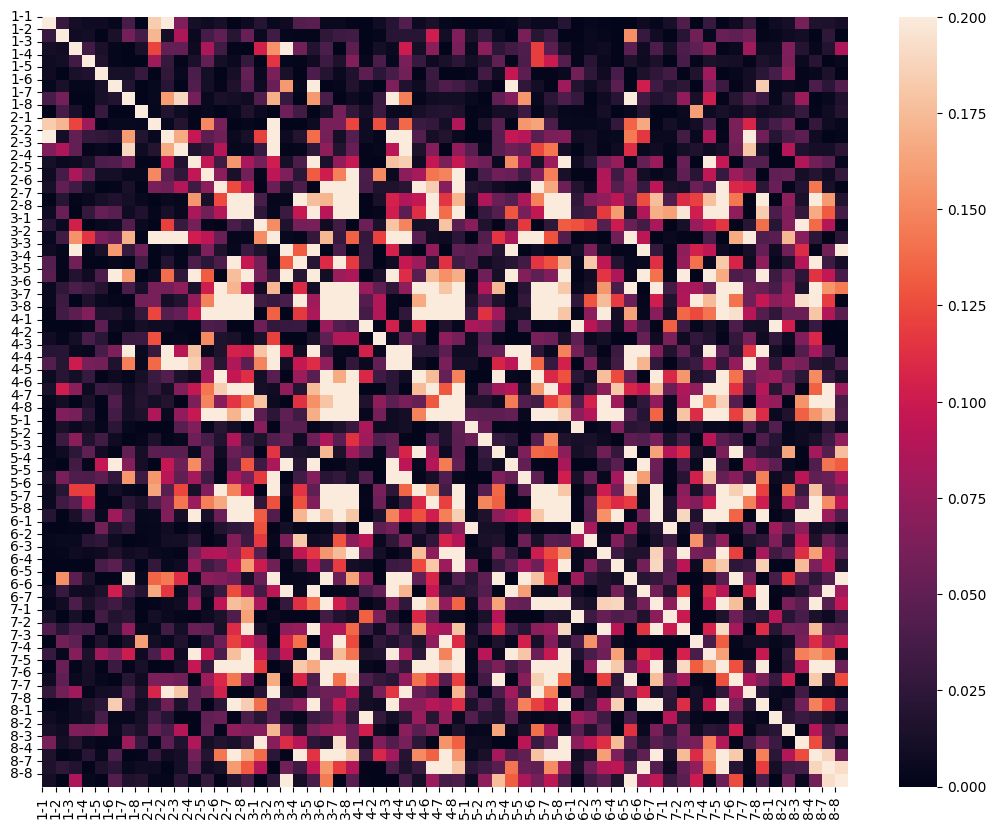

In [10]:
plt.figure(figsize=(13,10))

ax = sns.heatmap(hm, vmin=0, vmax=0.2)
ax.set_yticks(range(len(keys)))
ax.set_xticks(range(len(keys)))
ax.set_yticklabels(keys)
ax.set_xticklabels(keys)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig("pearson-corr.pdf")

In [95]:
# cluster them using T-SNE 
attn_scores_flat = {k: v.flatten() for k,v in attn_scores.items()}

ks = attn_scores_flat.keys()

In [96]:
import torch

In [97]:
stacked = torch.stack(list(attn_scores_flat.values()))

In [98]:
from sklearn.manifold import TSNE

In [116]:
tsne = TSNE(perplexity=2)

In [117]:
sned_data = tsne.fit_transform(stacked)

In [150]:
sns.set_style("whitegrid")
plt.style.use('alan.mplstyle')

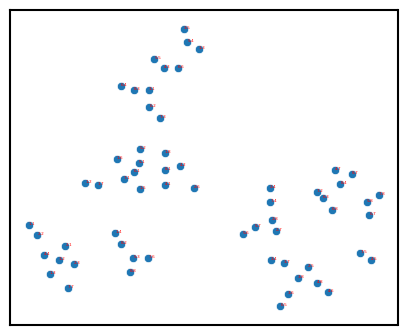

In [161]:
plt.figure(figsize=(5,5))

ax = sns.scatterplot(x=sned_data[:,0], y=sned_data[:,1])



ax.set_ylim(min(sned_data[:,1] - 5), max(sned_data[:,1]) + 5)
ax.set_xlim(min(sned_data[:,0] - 5), max(sned_data[:,0]) + 5)

ax.set_yticks([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_aspect(1, adjustable='box')

plt.savefig("tsned-no-labels.pdf")

for i, k in enumerate(ks):
    plt.text(sned_data[i,0],sned_data[i,1],k, color='red', fontsize=3)

plt.savefig("tsned.pdf")

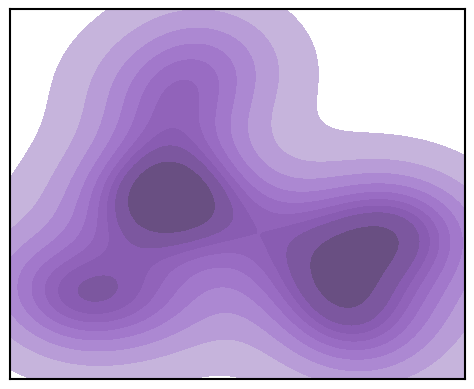

In [157]:
ax = sns.kdeplot(x=sned_data[:,0], y=sned_data[:,1], fill=True, color=(63/255,36/255,86/255,1))
ax.set_xlim(min(sned_data[:,0] - 5), max(sned_data[:,0]) + 5)
ax.set_ylim(min(sned_data[:,1] - 5), max(sned_data[:,1]) + 5)
ax.set_aspect("equal")


ax.set_yticks([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])


plt.savefig("kde-tsned.pdf")